<a href="https://colab.research.google.com/github/desmond-rn/projet-inverse-2d/blob/master/src/notebook/Regression90x90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'objectif est de prédire la position et la hauteur d'un saut de densité (créneau) $\rho$, à partir de $E_l, E_d, E_r, E_u$ (energie des photons), $F_l, F_d, F_r, F_u$ (flux des photons), et $T_l, T_d, T_r, T_u$ (temperature du milieu) sur les bords du domaine en tout temps.

In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import keras
import random
import sklearn

from ast import literal_eval as l_eval

In [ ]:
from keras import layers
from keras import models
from keras import utils 
from keras import losses
from keras import metrics
from keras import optimizers
from keras import backend as K
from sklearn import metrics

In [ ]:
np.set_printoptions(precision = 3)

In [ ]:
""" DEPUIS GOOGLE DRIVE """

# from google.colab import drive
# drive.mount('/gdrive')

' DEPUIS GOOGLE DRIVE '

In [ ]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/Projet\ inverse/2D/Apprentissage2/Data
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/Projet inverse/2D/Apprentissage2/Data

part10.sds  part2.sds  part4.sds  part6.sds  part8.sds
part1.sds   part3.sds  part5.sds  part7.sds  part9.sds


# PREPARATION

## Chargement des données

Les donnees contiennent contiennent $\rho$, $E$, $F$, et $T$. Elles sont sauvegardées dans un format binaire intitulé **SDS** (source-densité-signal). La version 01 de ce format est structurée dans l'ordre ci-après (l'en-tete du fichier est compris entre les lignes horizontales, et le reste represente la structure d'une des simulations presente dans le fichier):

---
- **`5`** octets pour la constante magique **sds01**
- __`2`__ octets pour le nombre de simulations presentes dans le fichier
- __`2`__ octets pour `N` (nombre de mailles en horizontale)
- __`2`__ octets pour `M` (nombre de mailles en verticale)
- __`2`__ octets pour `step_count` (nombre d'iterations en temps)
- **`1`** octet pour le charactere 0xA (newline)
---
- **`1`** octet pour le bord sur lequel se trouve la source: (0 pour up, 1 pour down, 2 pour left, 3 pour right, et -1 si aucun de ces 4)
- **`1`** octet pour la position de la source sur son bord: (0 pour (0.1, 0.3), 1 pour (0.3, 0.5), 2 pour (0.5, 0.7), 3 pour (0.7, 0.9), et -1 si aucun de ces 4)
- __`4 * 4`__ octets pour les attributs du crenau de densite: 4 octets (float) pour l'abcisse, 4 pour l'ordonee, 4 pour la valeur de la densite en dehors du crenau, et 4 pour la  hauteur du crenau.
- **`step_count * N * 4`** octets pour E_up
- idem pour F_up
- idem pour T_up
- **`step_count * N * 4`** octets pour E_down
- idem pour F_up
- idem pour T_up
- **`step_count * M * 4`** octets pour E_left
- idem pour F_left
- idem pour T_left
- **`step_count * M * 4`** octets pour E_right
- idem pour F_right
- idem pour T_right
- **`1`** octet pour le charactere 0xA (newline)

In [ ]:
""" Fonction pour lire le format binaire SDS """

def read_sds_version01(file_path):

  file = open(file_path, "rb")

  sds_version = file.read(5)
  assert(sds_version == b'sds01')

  simu_count = int.from_bytes(file.read(2), byteorder='little', signed=False)
  N = int.from_bytes(file.read(2), byteorder='little', signed=False)
  M = int.from_bytes(file.read(2), byteorder='little', signed=False)
  step_count = int.from_bytes(file.read(2), byteorder='little', signed=False)

  assert(file.read(1) == b'\n')

  X = np.zeros(shape=(simu_count // 4, step_count, N, 4, 4, 3), dtype=np.float32)
  y = np.zeros(shape=(simu_count // 4, 4), dtype=np.float32)

  index = 0
  pos_count = 0
  while True:
    next_byte = file.read(1)
    if next_byte == b'':
      break

    source_edge = int.from_bytes(next_byte, byteorder='little', signed=True)
    source_pos = int.from_bytes(file.read(1), byteorder='little', signed=True)
    assert (source_edge != -1 and source_pos != -1)
    # print("index", index)
    # print("source ", source_edge, source_pos)

    rho_attr = file.read(4*4)
    y[index, :] = np.frombuffer(rho_attr, dtype=np.float32)

    for e in range(4):
      for ch in range(3):
        signal = file.read(step_count*N*4)
        X[index, :, :, e, source_pos, ch] = np.frombuffer(signal, dtype=np.float32).reshape(step_count, N)

    assert(file.read(1) == b'\n')
    pos_count += 1
    if pos_count == 4:
      index += 1
      pos_count = 0

  return X, y

L'expression des opacites pour ces simulation est $\sigma_a = \sigma_c = T\times(10\times\rho)^3$ afin d'obtenir un maximum de diffusion de l'onde au niveau de l'obstacle tout en se propageant en dehors de l'obstacle.

La hauteur du crenau vaut a chaque fois $1$, et $4$ sources sont placées sur le bord gauche du domaine. On a dans chaque partie $4 \times 40 = 160$ positions. 

- **PART 1**: `[0.2, ..., 0.246] x [0.3, ..., 0.7]`  

- **PART 2**: `[0.262, ..., 0.308] x [0.3,  ..., 0.7]`

- **PART 3**: `[0.323, ..., 0.369] x [0.3,  ..., 0.7]`

- **PART 4**: `[0.385, ..., 0.431] x [0.3,  ..., 0.7]`

- **PART 5**: `[0.446, ..., 0.492] x [0.3, ..., 0.7]`

- **PART 6**: `[0.508, ..., 0.554] x [0.3, ..., 0.7]`

- **PART 7**: `[0.569, ..., 0.615] x [0.3, ..., 0.7]`

- **PART 8**: `[0.631, ..., 0.677] x [0.3, ..., 0.7]`

- **PART 9**: `[0.292, ..., 0.738] x [0.3, ..., 0.7]`

- **PART 10**: `[0.754, ..., 0.8] x [0.3, ..., 0.7]`



On a aut total 10 parties contenant 160 positions chacunes. Aussi, chaque simulation a necessite 168 iterations sur un maillage de 28 x 28.  On peut donc creer $X$ sous la forme `(10, 160, 168, 28, 4, 4, 3)`.
- le premier 4 represente le nombre de bords du domaine
- le deuxieme 4 represente le nombre de sources differentes sur le bord gauche
- le 3 represente le nombre de canaux ($E$, $F$ et $T$).

On cree $y$ sous la forme `(1600, 4)`. Le 4 represente le nombre d'attributs du crenau sur la densite. Seuls l'abcisse et l'ordonee du crenau nous intéressent (1er et 2e attributs).

In [ ]:
n_parts = 10
n_pos = 160
step_count = 168
N = 28 # N=M
n_edges = 4
n_sources = 4
n_channels = 3

n_attr = 4

X = np.zeros(shape=(n_parts, n_pos, step_count, N, n_edges, n_sources, n_channels), dtype=np.float32)
y = np.zeros(shape=(n_parts, n_pos, n_attr), dtype=np.float32)

for i in range(n_parts):
  X[i], y[i] = read_sds_version01("part"+str(i+1)+".sds")

print("Les dimensions preliminaires:\n")
print("X shape:", X.shape)
print("y shape:", y.shape)

Les dimensions preliminaires:

X shape: (10, 160, 168, 28, 4, 4, 3)
y shape: (10, 160, 4)


## Separation des données

Avant de separer en train, val et test, il faut normaliser et reshape X. Il faut aussi rendomiser X et y.

In [ ]:
""" On fait une simple normalisation des donnnees. Division par le maximum de valeur absolue de sur chaque canal de X """

# Une fonction pour detecter le min et le max d'un tenseur en excluant les NaN
def min_max(mat, dim=2):
  mat_min = mat
  for i in range(dim-1, -1, -1):
      mat_min = np.nanmin(mat_min, axis=i)
      
  mat_max = mat
  for i in range(dim-1, -1, -1):
      mat_max = np.nanmax(mat_max, axis=i)

  return mat_min, mat_max

min_E, max_E = min_max(np.abs(X[:, :, :, :, :, :, 0]), 3)
min_F, max_F = min_max(np.abs(X[:, :, :, :, :, :, 1]), 3)
min_T, max_T = min_max(np.abs(X[:, :, :, :, :, :, 2]), 3)

X[:, :, :, :, :, :, 0] = X[:, :, :, :, :, :, 0] / max_E
X[:, :, :, :, :, :, 1] = X[:, :, :, :, :, :, 1] / max_F
X[:, :, :, :, :, :, 2] = X[:, :, :, :, :, :, 2] / max_T

In [ ]:
""" On reshape X sous la forme (n_pos_total, step_count, N, 4*4*3) """
X = X.reshape((n_parts, n_pos, step_count, N, n_edges * n_sources * n_channels))

X = X.reshape((-1, step_count, N, n_edges * n_sources * n_channels))

In [ ]:
n_samples = len(X)
print("X shape =", X.shape)

X shape = (1600, 168, 28, 48)


In [ ]:
""" verifier qu'aucun des X n'est completement vide (null)  """
for i in range(n_samples):
  assert np.all(X[i] == 0) == False

In [ ]:
""" On reshape y et on extrait juste ses deux premieres colones """
y = y.reshape((-1, n_attr))
y = y[:, :2]

In [ ]:
n_targets = len(y)
print("y shape =", y.shape)

y shape = (1600, 2)


In [ ]:
""" On fait une permutation des entrees et sorties """
shuffle = np.arange(n_samples)
random.shuffle(shuffle)

X_copy = X.copy()
y_copy = y.copy()

for i in range(n_samples):
  X_copy[i] = X[shuffle[i]]
  y_copy[i] = y[shuffle[i]]

X = X_copy
y = y_copy

In [ ]:
len_train, len_val = 7*len(X)//10, 2*len(X)//10

X_train = X[:len_train]
X_val = X[len_train:len_train+len_val]
X_test = X[len_train+len_val:]

y_train = y[:len_train]
y_val = y[len_train:len_train+len_val]
y_test = y[len_train+len_val:]

print("X shapes =", np.shape(X_train), np.shape(X_val), np.shape(X_test))
print("y shapes =", np.shape(y_train), np.shape(y_val), np.shape(y_test))

X shapes = (1120, 168, 28, 48) (320, 168, 28, 48) (160, 168, 28, 48)
y shapes = (1120, 2) (320, 2) (160, 2)


In [ ]:
""" Sauvegarde de ce jeu de donnees pour un prochain apprentissage """
np.save("../Labels/train", y_train)
np.save("../Labels/val", y_val)
np.save("../Labels/test", y_test)

## Chargement au format Numpy

In [ ]:
%cd ..
print()
%ls

/gdrive/My Drive/Colab Notebooks/Projet inverse/2D/Apprentissage2


In [ ]:
""" Les constantes """
n_parts = 10
n_pos = 160
step_count = 168
N = 28 # N=M
n_edges = 4
n_sources = 4
n_channels = 3

n_attr = 4

In [ ]:
""" Chargement des donnnees """

X_train = np.load("Samples/train.npy")
X_val = np.load("Samples/val.npy")
X_test = np.load("Samples/test.npy")

y_train = np.load("Labels/train.npy")
y_val = np.load("Labels/val.npy")
y_test = np.load("Labels/test.npy")

In [ ]:
print("Les dimensions des donnees:\n")
print("X shapes:", X_train.shape, X_val.shape, X_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)

Les dimensions des donnees:

X shapes: (1120, 168, 28, 48) (320, 168, 28, 48) (160, 168, 28, 48)
y shapes: (1120, 2) (320, 2) (160, 2)


# APPRENTISSAGE

## Configuration du modèle 

In [ ]:
""" Un modèle convolutif """
model = models.Sequential(name="Convoluted_DRNN")

kernel_size = (6, 2)
strides = (1, 1)

model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu', input_shape=(step_count, N, n_edges * n_sources * n_channels)))
model.add(layers.Conv2D(32, kernel_size, strides=strides, activation='relu'))

# model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu'))
model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu'))

# model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, kernel_size, strides=strides, activation='relu'))
model.add(layers.Conv2D(128, kernel_size, strides=strides, activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(2, activation='linear'))

model.summary()

Model: "Convoluted_DRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 163, 27, 64)       36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 158, 26, 32)       24608     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 153, 25, 64)       24640     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 148, 24, 64)       49216     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 143, 23, 128)      98432     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 138, 22, 128)      196736    
_________________________________________________________________
flatten_2 (Flatten)          (None, 388608)        

Pour la compilation:
- on utlise l'optimiseur Adam
- on utlise la `mse` pour fonction loss
- on observe le coefficient de determination

In [ ]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=-1) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=-1)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=keras.losses.mse,
              # metrics=[keras.metrics.mean_absolute_error]
              # metrics=[keras.metrics.MeanAbsolutePercentageError(name="accuracy", dtype=None)]
              # metrics=[keras.metrics.CosineSimilarity(name="accuracy", dtype=None, axis=-1)]
              metrics=[r2_score]
              )

In [ ]:
""" Pour une decroissance du taux d'apprentissage """
def scheduler(epoch, lr):
  if epoch == 0:
    return 0.001
  else:
    return 0.8 * lr

callback = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor="r2_score", mode="max", restore_best_weights=True)

In [ ]:
""" Technique d'aumentation du batch size """

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/100
35/35 [==============================] - 10s 289ms/step - loss: 0.0258 - r2_score: -1.8362 - val_loss: 0.0035 - val_r2_score: 0.8554
Epoch 2/100
35/35 [==============================] - 10s 283ms/step - loss: 0.0011 - r2_score: 0.7567 - val_loss: 3.8661e-04 - val_r2_score: 0.9734
Epoch 3/100
35/35 [==============================] - 10s 281ms/step - loss: 2.3801e-04 - r2_score: 0.9410 - val_loss: 1.8767e-04 - val_r2_score: 0.9821
Epoch 4/100
35/35 [==============================] - 10s 285ms/step - loss: 1.4865e-04 - r2_score: 0.9804 - val_loss: 1.4263e-04 - val_r2_score: 0.9850
Epoch 5/100
35/35 [==============================] - 10s 280ms/step - loss: 1.2320e-04 - r2_score: 0.9431 - val_loss: 1.2182e-04 - val_r2_score: 0.9855
Epoch 6/100
35/35 [==============================] - 10s 286ms/step - loss: 1.0811e-04 - r2_score: 0.9836 - val_loss: 1.0252e-04 - val_r2_score: 0.9883
Epoch 7/100
35/35 [==============================] - 10s 280ms/step - loss: 1.0425e-04 - r2_score: 

In [ ]:
# """ Technique d'aumentation du batch size """

# def fit_increase(batch_sizes):
#   for i, bs in enumerate(batch_sizes):
#     print("STEP "+str(i+1), "/ 4", "- BATCH SIZE =", bs)
#     global history
#     history = model.fit(X_train,
#                         y_train,
#                         # epochs=int(4*(i+1)),
#                         epochs=5,
#                         batch_size=bs,
#                         # callbacks=[callback],
#                         validation_data=(X_val, y_val))
#     print()

# bbs = len(X_train) // 100  # base batch size
# fit_increase([bbs*1, bbs*5, bbs*10, bbs*20])

Verifions le taux d'apprentissage final.

In [ ]:
# """ ca devrait donner lr_init * decay_ratio ^ (n_epoch-1) """
# round(model.optimizer.lr.numpy(), 5)

Observons la decroissance de la loss

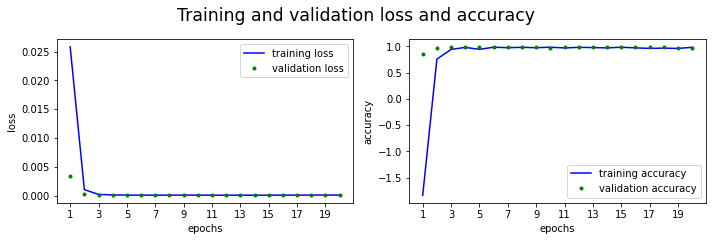

In [ ]:
history_dict = history.history

loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
acc = history_dict['r2_score']
val_acc = history_dict['val_r2_score']

epochs = range(1, len(loss)+1)
ticks = range(1, len(loss)+1, 2)

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10, 3))

ax0.plot(epochs, loss, 'b', label='training loss')
ax0.plot(epochs, val_loss, 'g.', label='validation loss')
# ax0.set_ylim(0, 0.3)
ax0.set_xticks(ticks)
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
# ax0.set_ylim(0, 1)
ax0.legend();

ax1.plot(epochs, acc, 'b', label='training accuracy')
ax1.plot(epochs, val_acc, 'g.', label='validation accuracy')
ax1.set_xticks(ticks)
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
# ax1.set_ylim(-1, 1)
ax1.legend();

plt.suptitle("Training and validation loss and accuracy", y=1.1, fontsize='xx-large')
plt.tight_layout()

In [ ]:
""" Sauvegardons les bons modeles qu'on obtient """
model.save('DRNN_2D_REC.h5', save_format='tf')

In [ ]:
""" Chargeons le modele """
model = keras.models.load_model("DRNN_2D_REC.tf", custom_objects={"r2_score": r2_score}, compile=False)
# model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=keras.losses.mse, metrics=[r2_score])

## Quelques predictions

In [ ]:
hat_y_test = model.predict(X_test)

In [ ]:
def print_prediction(hat_y_test, nb):
  start = len_train + len_val
  for i in range(0, n_targets-start, (n_targets-start)//nb):
    print("target:    ", y_test[i])
    print("prediction:", hat_y_test[i], "\n")

print_prediction(hat_y_test, 20)

target:     [0.246 0.341]
prediction: [0.219 0.338] 

target:     [0.4   0.659]
prediction: [0.395 0.661] 

target:     [0.677 0.505]
prediction: [0.656 0.517] 

target:     [0.4   0.587]
prediction: [0.392 0.59 ] 

target:     [0.308 0.3  ]
prediction: [0.293 0.307] 

target:     [0.738 0.495]
prediction: [0.716 0.483] 

target:     [0.246 0.433]
prediction: [0.219 0.449] 

target:     [0.369 0.659]
prediction: [0.358 0.661] 

target:     [0.477 0.649]
prediction: [0.467 0.662] 

target:     [0.569 0.597]
prediction: [0.561 0.588] 

target:     [0.8   0.505]
prediction: [0.785 0.521] 

target:     [0.584 0.628]
prediction: [0.577 0.629] 

target:     [0.492 0.567]
prediction: [0.468 0.554] 

target:     [0.584 0.351]
prediction: [0.577 0.334] 

target:     [0.769 0.567]
prediction: [0.749 0.555] 

target:     [0.631 0.69 ]
prediction: [0.608 0.693] 

target:     [0.431 0.536]
prediction: [0.41  0.535] 

target:     [0.692 0.608]
prediction: [0.684 0.612] 

target:     [0.416 0.433]
pr

In [ ]:
""" Le score r2 d'apres Keras """

print("r2 score on predictions: %.2f"%(100*model.evaluate(X_test, y_test)[1]), "%")

5/5 [==============================] - 0s 64ms/step - loss: 1.9353e-04 - r2_score: 0.9677
r2 score on predictions: 96.77 %


Deffinissons une mesure d'accuracy. 

On suppose la prediction correcte si elle est suffisament proche du label:
- au **dizième** près pour la position (suivant x ou y)
- à l'**unité** près pour la hauteur 

In [ ]:
""" Calculons l'accuracy """

condition1 = (abs(y_test[:, 0] - hat_y_test[:, 0]) <= .1)         # postition x
condition2 = (abs(y_test[:, 1] - hat_y_test[:, 1]) <= .1)         # postition y
# condition3 = (abs(y_test[:, 2] - hat_y_test[:, 2]) <= 1)          # hauteur

acc_pos_x = 100 * len(hat_y_test[condition1]) / len(hat_y_test)
acc_pos_y = 100 * len(hat_y_test[condition2]) / len(hat_y_test)
# acc_hgt = 100 * len(hat_y_test[condition3]) / len(hat_y_test)
# acc = 100 * len(hat_y_test[condition1 & condition2 & condition3]) / len(hat_y_test)

print("position x accuracy: %.2f"%acc_pos_x, "%")
print("position y accuracy: %.2f"%acc_pos_y, "%")

# print("height accuracy:     %.2f"%acc_hgt, "%")
# print()
# print("total accuracy:      %.2f"%acc, "%")

position x accuracy: 100.00 %
position y accuracy: 100.00 %


## Conclusion